# Nettoyage et selection des données

Après l'exploration des données nous allons mainteant sélectionné les données pour mener notre segmentation clients


In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

## Création du jeux de données


In [2]:
# Connect to database SQLite
conn = sqlite3.connect('olist.db')

# Create a cursor for interact with database
cursor = conn.cursor()

In [3]:
df_clients_request = """
WITH last_purchase AS (
    SELECT
        MAX(order_purchase_timestamp) AS max_purchase_date
    FROM
        orders
    WHERE
        order_status = 'delivered'
),

recency AS (
    SELECT
        c.customer_unique_id,
        MAX(o.order_purchase_timestamp) AS last_purchase_date,
        ROUND(JULIANDAY((SELECT max_purchase_date FROM last_purchase)) - JULIANDAY(MAX(o.order_purchase_timestamp)), 0) AS recency
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id
),

frequency AS (
    SELECT 
        c.customer_unique_id, 
        COUNT(o.order_id) AS frequency  
    FROM 
        customers c  
    JOIN 
        orders o ON c.customer_id = o.customer_id  
    WHERE 
        o.order_status = 'delivered'  
    GROUP BY 
        c.customer_unique_id
),

monetary AS (
    SELECT 
        c.customer_unique_id,  
        SUM(oi.price) AS monetary  
    FROM 
        customers c  
    JOIN 
        orders o ON c.customer_id = o.customer_id  
    JOIN 
        order_items oi ON o.order_id = oi.order_id  
    WHERE 
        o.order_status = 'delivered'  
    GROUP BY 
        c.customer_unique_id
),

preferred_payment_type AS (
    SELECT
        c.customer_unique_id,
        op.payment_type,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN 
        order_pymts op ON o.order_id = op.order_id  
    GROUP BY
        c.customer_unique_id, op.payment_type
),

preferred_payment_type_ranked AS (
    SELECT
        customer_unique_id,
        payment_type,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY count DESC) as rank
    FROM
        preferred_payment_type
),

day_with_most_orders AS (
    SELECT
        c.customer_unique_id,
        STRFTIME('%w', o.order_purchase_timestamp) AS day_of_week,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id, day_of_week
),

day_with_most_orders_ranked AS (
    SELECT
        customer_unique_id,
        day_of_week,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY count DESC) as rank
    FROM
        day_with_most_orders
),

preferred_product_category AS (
    SELECT
        c.customer_unique_id,
        t.product_category_name_english,
        SUM(oi.price) AS total_spent,
        COUNT(*) as count
    FROM
        customers c
    JOIN
        orders o ON c.customer_id = o.customer_id
    JOIN
        order_items oi ON o.order_id = oi.order_id
    JOIN
        products p ON oi.product_id = p.product_id
    JOIN
        translation t ON p.product_category_name = t.product_category_name
    WHERE
        o.order_status = 'delivered'
    GROUP BY
        c.customer_unique_id, t.product_category_name_english
),

preferred_product_category_ranked AS (
    SELECT
        customer_unique_id,
        product_category_name_english,
        ROW_NUMBER() OVER(PARTITION BY customer_unique_id ORDER BY total_spent DESC, count DESC) as rank
    FROM
        preferred_product_category
    GROUP BY
        customer_unique_id, product_category_name_english
)

SELECT
    r.customer_unique_id,
    r.recency,
    f.frequency,
    m.monetary,
    pp.payment_type AS preferred_payment_type,
    c.customer_city,
    c.customer_state,
    CASE
        WHEN dw.day_of_week = '0' THEN 'Dimanche'
        WHEN dw.day_of_week = '1' THEN 'Lundi'
        WHEN dw.day_of_week = '2' THEN 'Mardi'
        WHEN dw.day_of_week = '3' THEN 'Mercredi'
        WHEN dw.day_of_week = '4' THEN 'Jeudi'
        WHEN dw.day_of_week = '5' THEN 'Vendredi'
        WHEN dw.day_of_week = '6' THEN 'Samedi'
        ELSE 'Inconnu'
    END AS jour_avec_plus_de_commandes,
    pc.product_category_name_english AS catégorie_préférée
FROM
    recency r
JOIN
    frequency f ON r.customer_unique_id = f.customer_unique_id
JOIN
    monetary m ON r.customer_unique_id = m.customer_unique_id
JOIN
    customers c ON r.customer_unique_id = c.customer_unique_id
LEFT JOIN
    preferred_payment_type_ranked pp ON r.customer_unique_id = pp.customer_unique_id AND pp.rank = 1
LEFT JOIN
    day_with_most_orders_ranked dw ON r.customer_unique_id = dw.customer_unique_id AND dw.rank = 1
LEFT JOIN
    preferred_product_category_ranked pc ON r.customer_unique_id = pc.customer_unique_id AND pc.rank = 1
ORDER BY
    r.customer_unique_id;
"""


df_client = pd.read_sql_query(df_clients_request, conn)

# Exécution de la requête pour obtenir les dépenses par catégorie
df_spending_request = """
SELECT
    c.customer_unique_id,
    t.product_category_name_english,
    SUM(op.payment_value) AS total_spent
FROM
    customers c
JOIN
    orders o ON c.customer_id = o.customer_id
JOIN
    order_items oi ON o.order_id = oi.order_id
JOIN
    products p ON oi.product_id = p.product_id
JOIN
    translation t ON p.product_category_name = t.product_category_name
JOIN
    order_pymts op ON o.order_id = op.order_id
WHERE
    o.order_status = 'delivered'
GROUP BY
    c.customer_unique_id, t.product_category_name_english;
"""

df_spending = pd.read_sql_query(df_spending_request, conn)


# Pivot les dépenses par catégorie pour obtenir une colonne par catégorie
df_spending_pivot = df_spending.pivot(
    index='customer_unique_id', columns='product_category_name_english', values='total_spent').fillna(0)

# Renommer les colonnes en français pour les dépenses
df_spending_pivot.columns = [
    'dépense_' + col.replace(' ', '_').lower() for col in df_spending_pivot.columns]

# Fusionner les deux DataFrames
df_final = df_client.merge(
    df_spending_pivot, left_on='customer_unique_id', right_index=True, how='left')

# Renommer les colonnes en français
df_final = df_final.rename(columns={
    'customer_unique_id': 'identifiant_client',
    'recency': 'récence',
    'frequency': 'fréquence',
    'monetary': 'montant',
    'preferred_payment_type': 'type_de_paiement_préféré',
    'customer_city': 'ville_client',
    'customer_state': 'état_client',
    'jour_avec_plus_de_commandes': 'jour_avec_plus_de_commandes',
    'catégorie_préférée': 'catégorie_préférée'
})
df_final = df_final.set_index('identifiant_client')
display(df_final)

récence  fréquence  montant  \
identifiant_client                                              
0000366f3b9a7992bf8c76cfdf3221e2    111.0          1   129.90   
0000b849f77a49e4a4ce2b2a4ca5be3f    114.0          1    18.90   
0000f46a3911fa3c0805444483337064    537.0          1    69.00   
0000f6ccb0745a6a4b88665a16c9f078    321.0          1    25.99   
0004aac84e0df4da2b147fca70cf8255    288.0          1   180.00   
...                                   ...        ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684    447.0          1  1570.00   
fffea47cd6d3cc0a88bd621562a9d061    262.0          1    64.89   
ffff371b4d645b6ecea244b27531430a    568.0          1    89.90   
ffff5962728ec6157033ef9805bacc48    119.0          1   115.00   
ffffd2657e2aad2907e67c3e9daecbeb    484.0          1    56.99   

                                 type_de_paiement_préféré        ville_client  \
identifiant_client                                                              
0000366f3b9a7992bf8c76cfdf3221e2              credit_card             cajamar   
0000b849f77a49e4a4ce2b2a4ca5be3f              credit_card              osasco   
0000f46a3911fa3c0805444483337064              credit_card            sao jose   
0000f6ccb0745a6a4b88665a16c9f078              credit_card               belem   
0004aac84e0df4da2b147fca70cf8255              credit_card            sorocaba   
...                                                   ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684              credit_card             sanharo   
fffea47cd6d3cc0a88bd621562a9d061              credit_card    feira de santana   
ffff371b4d645b6ecea244b27531430a              credit_card               sinop   
ffff5962728ec6157033ef9805bacc48              credit_card  bom jesus do norte   
ffffd2657e2aad2907e67c3e9daecbeb              credit_card         campo largo   

                                 état_client jour_avec_plus_de_commandes  \
identifiant_client                                                         
0000366f3b9a7992bf8c76cfdf3221e2          SP                       Jeudi   
0000b849f77a49e4a4ce2b2a4ca5be3f          SP                       Lundi   
0000f46a3911fa3c0805444483337064          SC                    Vendredi   
0000f6ccb0745a6a4b88665a16c9f078          PA                       Jeudi   
0004aac84e0df4da2b147fca70cf8255          SP                       Mardi   
...                                      ...                         ...   
fffcf5a5ff07b0908bd4e2dbc735a684          PE                       Jeudi   
fffea47cd6d3cc0a88bd621562a9d061          BA                    Dimanche   
ffff371b4d645b6ecea244b27531430a          MT                       Mardi   
ffff5962728ec6157033ef9805bacc48          ES                    Mercredi   
ffffd2657e2aad2907e67c3e9daecbeb          PR                       Mardi   

                                 catégorie_préférée  \
identifiant_client                                    
0000366f3b9a7992bf8c76cfdf3221e2     bed_bath_table   
0000b849f77a49e4a4ce2b2a4ca5be3f      health_beauty   
0000f46a3911fa3c0805444483337064         stationery   
0000f6ccb0745a6a4b88665a16c9f078          telephony   
0004aac84e0df4da2b147fca70cf8255          telephony   
...                                             ...   
fffcf5a5ff07b0908bd4e2dbc735a684      health_beauty   
fffea47cd6d3cc0a88bd621562a9d061               baby   
ffff371b4d645b6ecea244b27531430a               auto   
ffff5962728ec6157033ef9805bacc48      watches_gifts   
ffffd2657e2aad2907e67c3e9daecbeb          perfumery   

                                  dépense_agro_industry_and_commerce  \
identifiant_client                                                     
0000366f3b9a7992bf8c76cfdf3221e2                                 0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                                 0.0   
0000f46a3911fa3c0805444483337064                                 0.0   
0000f6ccb0745a6a4b88665a16c9f078                                 0.0 

## Nettoyage du jeu de donnée

### Vérification des données manquantes

In [4]:
# Verify missing values
missing_values = df_final.isnull().sum()
print(missing_values)

récence                              0
fréquence                            0
montant                              0
type_de_paiement_préféré             1
ville_client                         0
                                  ... 
dépense_stationery                1287
dépense_tablets_printing_image    1287
dépense_telephony                 1287
dépense_toys                      1287
dépense_watches_gifts             1287
Length: 79, dtype: int64


Nous avons des données manquantes sur les catégories. Nous allons dans un premier temps remplacer 'catégorie_préférée' par la valeur la plus fréquente et ensuite imputer le montant des dépenses à la catégorie qui a été remplacer avec la méthode most_fréquent.

In [5]:
# Find the most_frequent value in the column
most_frequent_categories = df_final['catégorie_préférée'].mode()[0]

# Get the most frequent values
print(f"catégorie la plus fréquente est : {most_frequent_categories}")
# replace fillna by most frequent values
df_final['catégorie_préférée'].fillna(most_frequent_categories, inplace=True)

catégorie la plus fréquente est : bed_bath_table


/tmp/ipykernel_42729/4290771616.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['catégorie_préférée'].fillna(most_frequent_categories, inplace=True)


In [6]:
# Identify columns starting with 'dépense'
depense_columns = [
    col for col in df_final.columns if col.startswith('dépense')]

# Replace missing values in 'dépense_bed_bath_table' with values from 'montant'
df_final['dépense_bed_bath_table'].fillna(df_final['montant'], inplace=True)

# Replace missing values in other 'dépense' columns with zero
for col in depense_columns:
    if col != 'dépense_bed_bath_table':
        df_final[col].fillna(0, inplace=True)

/tmp/ipykernel_42729/1602913787.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['dépense_bed_bath_table'].fillna(df_final['montant'], inplace=True)
/tmp/ipykernel_42729/1602913787.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

In [7]:
# Drop rows with na values
df_final.dropna(inplace=True)
# Verify missing values
missing_values = df_final.isnull().sum()
print(missing_values)

récence                           0
fréquence                         0
montant                           0
type_de_paiement_préféré          0
ville_client                      0
                                 ..
dépense_stationery                0
dépense_tablets_printing_image    0
dépense_telephony                 0
dépense_toys                      0
dépense_watches_gifts             0
Length: 79, dtype: int64


### Vérification des valeurs dupliquées

In [8]:
# Check for duplicate rows
duplicates = df_final[df_final.duplicated()]

# Display the duplicate rows
print(f"Nombre de lignes dupliquées: {len(duplicates)}")
df_final = df_final.drop_duplicates()
# Verify if rows was dupplicated after transformation
num_duplicates = df_final.duplicated().sum()

# Display number of rows dupplicated
print(f"Nombre de lignes dupliquer après suppression: {num_duplicates}")

Nombre de lignes dupliquées: 3421
Nombre de lignes dupliquer après suppression: 0


### Analyse des outliers

In [9]:
# Create a subplot figure with 2 rows and 3 columns
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("Fréquence  Récence", "Fréquence  Fréquence", "Fréquence  Montant",
                    "Boxplot  Récence", "Boxplot  Fréquence", "Boxplot  Montant"),
    vertical_spacing=0.3
)

# Add histograms
fig.add_trace(
    px.histogram(df_final, x='récence').data[0],
    row=1, col=1
)
fig.add_trace(
    px.histogram(df_final, x='fréquence').data[0],
    row=1, col=2
)
fig.add_trace(
    px.histogram(df_final, x='montant').data[0],
    row=1, col=3
)

# Add box plots
fig.add_trace(
    go.Box(y=df_final['récence'], name='Récence'),
    row=2, col=1
)
fig.add_trace(
    go.Box(y=df_final['fréquence'], name='Fréquence'),
    row=2, col=2
)
fig.add_trace(
    go.Box(y=df_final['montant'], name='Montant'),
    row=2, col=3
)

# Update layout for better spacing
fig.update_layout(
    height=900,
    title_text=""
)

# Show the plot
fig.show()

Avec notre jeux de données nous n'allons pas supprimer d'outlier,en effet nos valeurs dans notre dataframe sont très disparatre ce qui est normal car les profils de nos utilisateurs sont très différentes

### Modification des catégories 

Nous allons regrouper les différentes catégories pour réduire les catégories représenter

In [10]:
# Maison
df_final['dépense_maison'] = (
    df_final['dépense_bed_bath_table'] +
    df_final['dépense_furniture_bedroom'] +
    df_final['dépense_furniture_decor'] +
    df_final['dépense_furniture_living_room'] +
    df_final['dépense_furniture_mattress_and_upholstery'] +
    df_final['dépense_housewares'] +
    df_final['dépense_home_confort'] +
    df_final['dépense_home_comfort_2'] +
    df_final['dépense_home_appliances'] +
    df_final['dépense_home_appliances_2']
)

# Électronique
df_final['dépense_électronique'] = (
    df_final['dépense_computers'] +
    df_final['dépense_computers_accessories'] +
    df_final['dépense_tablets_printing_image'] +
    df_final['dépense_telephony'] +
    df_final['dépense_fixed_telephony'] +
    df_final['dépense_electronics'] +
    df_final['dépense_audio'] +
    df_final['dépense_cine_photo']
)

# Mode
df_final['dépense_mode'] = (
    df_final['dépense_fashio_female_clothing'] +
    df_final['dépense_fashion_bags_accessories'] +
    df_final['dépense_fashion_childrens_clothes'] +
    df_final['dépense_fashion_male_clothing'] +
    df_final['dépense_fashion_shoes'] +
    df_final['dépense_fashion_sport'] +
    df_final['dépense_fashion_underwear_beach'] +
    df_final['dépense_luggage_accessories'] +
    df_final['dépense_watches_gifts']
)

# Loisirs et Divertissements
df_final['dépense_loisirs'] = (
    df_final['dépense_toys'] +
    df_final['dépense_sports_leisure'] +
    df_final['dépense_consoles_games'] +
    df_final['dépense_music'] +
    df_final['dépense_musical_instruments'] +
    df_final['dépense_party_supplies']
)

# Livres et Médias
df_final['dépense_médias'] = (
    df_final['dépense_books_general_interest'] +
    df_final['dépense_books_imported'] +
    df_final['dépense_books_technical'] +
    df_final['dépense_cds_dvds_musicals'] +
    df_final['dépense_dvds_blu_ray']
)

# Automobile et Outils
df_final['dépense_auto_outils'] = (
    df_final['dépense_auto'] +
    df_final['dépense_construction_tools_construction'] +
    df_final['dépense_construction_tools_lights'] +
    df_final['dépense_construction_tools_safety'] +
    df_final['dépense_costruction_tools_garden'] +
    df_final['dépense_costruction_tools_tools'] +
    df_final['dépense_garden_tools'] +
    df_final['dépense_air_conditioning']
)

# Santé et Beauté
df_final['dépense_santé_beauté'] = (
    df_final['dépense_health_beauty'] +
    df_final['dépense_perfumery'] +
    df_final['dépense_diapers_and_hygiene']
)

# Bébé et Enfant
df_final['dépense_bébé_enfant'] = (
    df_final['dépense_baby'] +
    df_final['dépense_diapers_and_hygiene']
)

# Cuisine et Restauration
df_final['dépense_cuisine'] = (
    df_final['dépense_food'] +
    df_final['dépense_food_drink'] +
    df_final['dépense_drinks'] +
    df_final['dépense_la_cuisine']
)

# Sécurité et Services
df_final['dépense_sécurité_services'] = (
    df_final['dépense_security_and_services'] +
    df_final['dépense_signaling_and_security']
)

# Drop ancient categories

delete_columns = [
    'dépense_agro_industry_and_commerce', 'dépense_air_conditioning', 'dépense_art',
    'dépense_arts_and_craftmanship', 'dépense_audio', 'dépense_auto', 'dépense_baby',
    'dépense_bed_bath_table', 'dépense_books_general_interest', 'dépense_books_imported',
    'dépense_books_technical', 'dépense_cds_dvds_musicals', 'dépense_christmas_supplies',
    'dépense_cine_photo', 'dépense_computers', 'dépense_computers_accessories',
    'dépense_consoles_games', 'dépense_construction_tools_construction', 'dépense_construction_tools_lights',
    'dépense_construction_tools_safety', 'dépense_cool_stuff', 'dépense_costruction_tools_garden',
    'dépense_costruction_tools_tools', 'dépense_diapers_and_hygiene', 'dépense_drinks',
    'dépense_dvds_blu_ray', 'dépense_electronics', 'dépense_fashio_female_clothing',
    'dépense_fashion_bags_accessories', 'dépense_fashion_childrens_clothes', 'dépense_fashion_male_clothing',
    'dépense_fashion_shoes', 'dépense_fashion_sport', 'dépense_fashion_underwear_beach',
    'dépense_fixed_telephony', 'dépense_flowers', 'dépense_food', 'dépense_food_drink',
    'dépense_furniture_bedroom', 'dépense_furniture_decor', 'dépense_furniture_living_room',
    'dépense_furniture_mattress_and_upholstery', 'dépense_garden_tools', 'dépense_health_beauty',
    'dépense_home_appliances', 'dépense_home_appliances_2', 'dépense_home_comfort_2',
    'dépense_home_confort', 'dépense_home_construction', 'dépense_housewares',
    'dépense_industry_commerce_and_business', 'dépense_kitchen_dining_laundry_garden_furniture',
    'dépense_la_cuisine', 'dépense_luggage_accessories', 'dépense_market_place', 'dépense_music',
    'dépense_musical_instruments', 'dépense_office_furniture', 'dépense_party_supplies',
    'dépense_perfumery', 'dépense_pet_shop', 'dépense_security_and_services',
    'dépense_signaling_and_security', 'dépense_small_appliances', 'dépense_small_appliances_home_oven_and_coffee',
    'dépense_sports_leisure', 'dépense_stationery', 'dépense_tablets_printing_image',
    'dépense_telephony', 'dépense_toys', 'dépense_watches_gifts'
]

# Suppression des colonnes
df_final.drop(columns=delete_columns, inplace=True)

In [11]:
display(df_final)

récence  fréquence  montant  \
identifiant_client                                              
0000366f3b9a7992bf8c76cfdf3221e2    111.0          1   129.90   
0000b849f77a49e4a4ce2b2a4ca5be3f    114.0          1    18.90   
0000f46a3911fa3c0805444483337064    537.0          1    69.00   
0000f6ccb0745a6a4b88665a16c9f078    321.0          1    25.99   
0004aac84e0df4da2b147fca70cf8255    288.0          1   180.00   
...                                   ...        ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684    447.0          1  1570.00   
fffea47cd6d3cc0a88bd621562a9d061    262.0          1    64.89   
ffff371b4d645b6ecea244b27531430a    568.0          1    89.90   
ffff5962728ec6157033ef9805bacc48    119.0          1   115.00   
ffffd2657e2aad2907e67c3e9daecbeb    484.0          1    56.99   

                                 type_de_paiement_préféré        ville_client  \
identifiant_client                                                              
0000366f3b9a7992bf8c76cfdf3221e2              credit_card             cajamar   
0000b849f77a49e4a4ce2b2a4ca5be3f              credit_card              osasco   
0000f46a3911fa3c0805444483337064              credit_card            sao jose   
0000f6ccb0745a6a4b88665a16c9f078              credit_card               belem   
0004aac84e0df4da2b147fca70cf8255              credit_card            sorocaba   
...                                                   ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684              credit_card             sanharo   
fffea47cd6d3cc0a88bd621562a9d061              credit_card    feira de santana   
ffff371b4d645b6ecea244b27531430a              credit_card               sinop   
ffff5962728ec6157033ef9805bacc48              credit_card  bom jesus do norte   
ffffd2657e2aad2907e67c3e9daecbeb              credit_card         campo largo   

                                 état_client jour_avec_plus_de_commandes  \
identifiant_client                                                         
0000366f3b9a7992bf8c76cfdf3221e2          SP                       Jeudi   
0000b849f77a49e4a4ce2b2a4ca5be3f          SP                       Lundi   
0000f46a3911fa3c0805444483337064          SC                    Vendredi   
0000f6ccb0745a6a4b88665a16c9f078          PA                       Jeudi   
0004aac84e0df4da2b147fca70cf8255          SP                       Mardi   
...                                      ...                         ...   
fffcf5a5ff07b0908bd4e2dbc735a684          PE                       Jeudi   
fffea47cd6d3cc0a88bd621562a9d061          BA                    Dimanche   
ffff371b4d645b6ecea244b27531430a          MT                       Mardi   
ffff5962728ec6157033ef9805bacc48          ES                    Mercredi   
ffffd2657e2aad2907e67c3e9daecbeb          PR                       Mardi   

                                 catégorie_préférée  dépense_maison  \
identifiant_client                                                    
0000366f3b9a7992bf8c76cfdf3221e2     bed_bath_table           141.9   
0000b849f77a49e4a4ce2b2a4ca5be3f      health_beauty             0.0   
0000f46a3911fa3c0805444483337064         stationery             0.0   
0000f6ccb0745a6a4b88665a16c9f078          telephony             0.0   
0004aac84e0df4da2b147fca70cf8255          telephony             0.0   
...                                             ...             ...   
fffcf5a5ff07b0908bd4e2dbc735a684      health_beauty             0.0   
fffea47cd6d3cc0a88bd621562a9d061               baby             0.0   
ffff371b4d645b6ecea244b27531430a               auto             0.0   
ffff5962728ec6157033ef9805bacc48      watches_gifts             0.0   
ffffd2657e2aad2907e67c3e9daecbeb          perfumery             0.0   

                                  dépense_électronique  dépense_mode  \
identifiant_client                                                     
0000366f3b9a7992bf8c76cfdf3221e2                  0.00          0.00   
0000b

## Analyse des corrélations du jeu de données

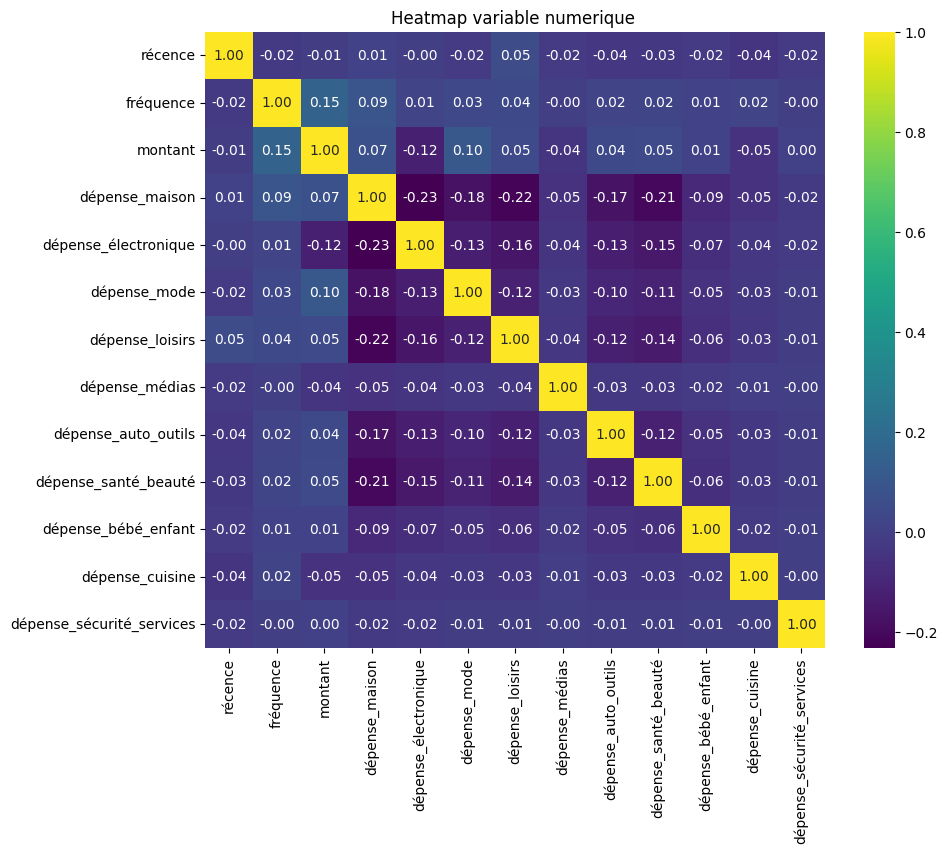

In [12]:
# Set 'identifiant_client' as the index
# df_final.set_index('identifiant_client', inplace=True)

# Filter the DataFrame to include only integer columns

df_numeric = df_final.select_dtypes(include=['int64', 'float64'])
# Calculate the correlation matrix
correlation_matrix = df_numeric.corr(method='spearman')
# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap variable numerique ')
plt.show()

## Preprocessing des données

In [13]:
# # Create a copy of df_final for preprocessing
# df_processed = df_final.copy()

# # Select categorical and numerical columns
# cat_cols = df_processed.select_dtypes(include=['object']).columns
# num_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns

# # Create a LabelEncoder object
# le = LabelEncoder()

# for col in cat_cols:
#     # Fit and transform the categorical data on the processed DataFrame only
#     df_processed[col] = le.fit_transform(df_processed[col])

# # Standardize numerical columns
# scaler = StandardScaler()
# df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

In [14]:
# Create a copy of the original dataframe
df_processed = df_final.copy()

# Identify categorical and numerical columns
# cat_cols = df_processed.select_dtypes(include=['object']).columns
num_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns

# Initialize the OneHotEncoder and StandardScaler
categorical_processing = OneHotEncoder(sparse_output=False, drop='first')
scaler = StandardScaler()

# Standardize numerical columns
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

# Apply OneHotEncoder to categorical columns
# encoded_cats = categorical_processing.fit_transform(df_processed[cat_cols])

# Convert the encoded categorical columns to a DataFrame
# encoded_cats_df = pd.DataFrame(
#     encoded_cats,
#     columns=categorical_processing.get_feature_names_out(cat_cols)
# )

# Ensure the indices align
# encoded_cats_df.index = df_processed.index

# Drop the original categorical columns
# df_processed = df_processed.drop(cat_cols, axis=1)

# Concatenate the original DataFrame with the new one-hot encoded columns
# df_processed = pd.concat([df_processed, encoded_cats_df], axis=1)

In [15]:
display(df_processed)

récence  fréquence   montant  \
identifiant_client                                                
0000366f3b9a7992bf8c76cfdf3221e2 -0.828877  -0.163448 -0.055500   
0000b849f77a49e4a4ce2b2a4ca5be3f -0.809219  -0.163448 -0.569596   
0000f46a3911fa3c0805444483337064  1.962570  -0.163448 -0.337558   
0000f6ccb0745a6a4b88665a16c9f078  0.547188  -0.163448 -0.536759   
0004aac84e0df4da2b147fca70cf8255  0.330950  -0.163448  0.176538   
...                                    ...        ...       ...   
fffcf5a5ff07b0908bd4e2dbc735a684  1.372828  -0.163448  6.614317   
fffea47cd6d3cc0a88bd621562a9d061  0.160580  -0.163448 -0.356594   
ffff371b4d645b6ecea244b27531430a  2.165703  -0.163448 -0.240760   
ffff5962728ec6157033ef9805bacc48 -0.776455  -0.163448 -0.124509   
ffffd2657e2aad2907e67c3e9daecbeb  1.615277  -0.163448 -0.393183   

                                 type_de_paiement_préféré        ville_client  \
identifiant_client                                                              
0000366f3b9a7992bf8c76cfdf3221e2              credit_card             cajamar   
0000b849f77a49e4a4ce2b2a4ca5be3f              credit_card              osasco   
0000f46a3911fa3c0805444483337064              credit_card            sao jose   
0000f6ccb0745a6a4b88665a16c9f078              credit_card               belem   
0004aac84e0df4da2b147fca70cf8255              credit_card            sorocaba   
...                                                   ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684              credit_card             sanharo   
fffea47cd6d3cc0a88bd621562a9d061              credit_card    feira de santana   
ffff371b4d645b6ecea244b27531430a              credit_card               sinop   
ffff5962728ec6157033ef9805bacc48              credit_card  bom jesus do norte   
ffffd2657e2aad2907e67c3e9daecbeb              credit_card         campo largo   

                                 état_client jour_avec_plus_de_commandes  \
identifiant_client                                                         
0000366f3b9a7992bf8c76cfdf3221e2          SP                       Jeudi   
0000b849f77a49e4a4ce2b2a4ca5be3f          SP                       Lundi   
0000f46a3911fa3c0805444483337064          SC                    Vendredi   
0000f6ccb0745a6a4b88665a16c9f078          PA                       Jeudi   
0004aac84e0df4da2b147fca70cf8255          SP                       Mardi   
...                                      ...                         ...   
fffcf5a5ff07b0908bd4e2dbc735a684          PE                       Jeudi   
fffea47cd6d3cc0a88bd621562a9d061          BA                    Dimanche   
ffff371b4d645b6ecea244b27531430a          MT                       Mardi   
ffff5962728ec6157033ef9805bacc48          ES                    Mercredi   
ffffd2657e2aad2907e67c3e9daecbeb          PR                       Mardi   

                                 catégorie_préférée  dépense_maison  \
identifiant_client                                                    
0000366f3b9a7992bf8c76cfdf3221e2     bed_bath_table        0.387934   
0000b849f77a49e4a4ce2b2a4ca5be3f      health_beauty       -0.220815   
0000f46a3911fa3c0805444483337064         stationery       -0.220815   
0000f6ccb0745a6a4b88665a16c9f078          telephony       -0.220815   
0004aac84e0df4da2b147fca70cf8255          telephony       -0.220815   
...                                             ...             ...   
fffcf5a5ff07b0908bd4e2dbc735a684      health_beauty       -0.220815   
fffea47cd6d3cc0a88bd621562a9d061               baby       -0.220815   
ffff371b4d645b6ecea244b27531430a               auto       -0.220815   
ffff5962728ec6157033ef9805bacc48      watches_gifts       -0.220815   
ffffd2657e2aad2907e67c3e9daecbeb          perfumery       -0.220815   

                                  dépense_électronique  dépense_mode  \
identifiant_client                                                     
0000366f3b9a7992bf8c76cfdf3221e2             -0.0653

## Export des données pour modelisation

In [16]:
df_processed.to_csv('./df_preprocessing.csv')